In [1]:
import numpy as np
import pandas as pd
import glob
import locale
import os.path
import requests
import sys
import codecs
from smart_open import smart_open
import re
import spacy
import string
import pickle as pkl
import torch
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
import copy 

Load data from folder:

In [42]:
def load_IMDB(folderpath, pos = True):
    read_files = glob.glob(folderpath)
    data_dict = {}
    data_dict['data'] = []
    data_dict['target'] = []
    data_dict['filenames']= []
    if pos:
        target_value = 1
    else: 
        target_value = 0
    for f in read_files:
        with open(f, "rb") as infile:
            data_dict['data'].append(normalize_text(infile.read().decode("utf-8")))
            data_dict['target'].append(target_value)
            data_dict['filenames'].append(f)
    return data_dict

# initial clean on raw data
def normalize_text(text):
    norm_text = text.lower()
    norm_text = norm_text.replace('<br />', ' ')
    norm_text = re.sub(r"([\.\",\(\)!\?;:-])", "", norm_text)
    norm_text = norm_text.replace('  ', ' ')
    return norm_text

In [30]:
train_pos = load_IMDB("aclImdb-2/train/pos/*.txt", pos = True)
train_neg = load_IMDB("aclImdb-2/train/neg/*.txt", pos = False)
test_pos = load_IMDB("aclImdb-2/test/pos/*.txt", pos = True)
test_neg = load_IMDB("aclImdb-2/test/neg/*.txt", pos = False)

In [31]:
# Split train data into actual train and validation sets

train_split = 10000
train_data = train_pos['data'][:train_split] +  train_neg['data'][:train_split]
train_targets = train_pos['target'][:train_split] +  train_neg['target'][:train_split]

val_data = train_pos['data'][train_split:] +  train_neg['data'][train_split:]
val_targets = train_pos['target'][train_split:] +  train_neg['target'][train_split:]

test_data = test_pos['data']+  test_neg['data']
test_targets = test_pos['target']+  test_neg['target']

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [58]:
print(train_data[100])
print(train_targets[100])

sure it was cheesy and nonsensical and at times corny but at least the filmmakers didn't try while most tv movies border on the brink of mediocrity this film actually has some redeeming qualities to it the cinematography was pretty good for a tv film and viggo mortensen displays shades of aragorn in a film about a man who played by his own rules most of the flashback sequences were kind of cheesy but the scene with the mountain lion was intense i was kind of annoyed by jason priestly's role in the film as a rebellious shockjock but then again it's a tv movie despite all of the good things the soundtrack was atrocious however it was nice to see tucson arizona prominently featured in the film
1


Tokenization:

In [109]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens

In [113]:
#valication set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

#test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

#train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [76]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

Generate n-grams:

In [3]:
# this is the n-gram function for `all_train_tokens` 
def build_n_gram(tokens, gram):
    n_gram_tokens = []
    for docu in tokens:
        for i in range(len(docu)-gram+1):
            n_gram_tokens.append(' '.join(docu[i:i+gram]))
    return n_gram_tokens

In [4]:
def build_n_gram_trainset(tokens, gram):
    for docu in tokens:
        fix_l = len(docu)
        for n in range(2,gram+1):
            ngrams_list = []
            for i in range(fix_l-gram +1):
                ngram = ' '.join(docu[i:i + n])
                ngrams_list.append(ngram)
            docu.extend(ngrams_list)
    return tokens

In [5]:
# 2-gram vocabulary
train_data_tokens_2 = build_n_gram(train_data_tokens, gram = 2) + all_train_tokens
# 3-gram vocabulary
train_data_tokens_3 = build_n_gram(train_data_tokens, gram = 3) + train_data_tokens_2
# 4-gram vocabulary
train_data_tokens_4 = build_n_gram(train_data_tokens, gram = 4) + train_data_tokens_3

In [10]:
train_data_tokens_2_train = build_n_gram_trainset(train_data_tokens, 2)
train_data_tokens_3_train = build_n_gram_trainset(train_data_tokens, 3)
train_data_tokens_4_train = build_n_gram_trainset(train_data_tokens, 4)

In [16]:
val_data_tokens_2_val = build_n_gram_trainset(val_data_tokens, 2)
val_data_tokens_3_val = build_n_gram_trainset(val_data_tokens, 3)
val_data_tokens_4_val = build_n_gram_trainset(val_data_tokens, 4)

In [21]:
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

In [22]:
test_data_tokens_2_test = build_n_gram_trainset(test_data_tokens, 2)
test_data_tokens_3_test = build_n_gram_trainset(test_data_tokens, 3)
test_data_tokens_4_test = build_n_gram_trainset(test_data_tokens, 4)

Now, we are going to create the vocabulary of most common [`10,000`, `20,000`, `40,000`] tokens in the training set.

In [24]:
from collections import Counter

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [77]:
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 13447 ; token bozz
Token bozz; token id 13447


In [78]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Now we are going to create PyTorch DataLoader

First to find out the max sentence length:

In [27]:
sentence_len = []
for i in range(len(train_data_indices)):
    sentence_len.append(len(train_data_indices[i]))
print('The maximum sentense length is',max(sentence_len))

The maximum sentense length is 9955


In [81]:
MAX_SENTENCE_LENGTH = max(sentence_len)

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

for i, (data, lengths, labels) in enumerate(train_loader):
    print (data)
    print(lengths)
    print (labels)
    break

tensor([[   2,   18,  390,  ...,    0,    0,    0],
        [  11,    7,   30,  ...,    0,    0,    0],
        [1368,   11,   20,  ...,    0,    0,    0],
        ...,
        [6413,   10,   42,  ...,    0,    0,    0],
        [ 134,   11,   18,  ...,    0,    0,    0],
        [  11,   18, 8725,  ...,    0,    0,    0]])
tensor([115, 519, 153,  61, 141, 404, 364, 111, 229, 275, 243, 492, 259, 429,
        267, 455, 132,  54, 191, 127, 134, 103, 100, 151, 296, 117, 201, 122,
        147, 135, 204, 196])
tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 0])


Here we will define Bag-of-Words model in PyTorch

In [44]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [45]:
learning_rate = 0.01
num_epochs = 3 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader))

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

#################
val_acc_l_LR_dic20000= []
#################
step_l = []
loss_l = []
loss_step = []
for epoch in range(num_epochs):
    #scheduler.step(epoch)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        # have to zero them out at the start of a new minibatch
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_l.append(loss)
        loss_step.append(i)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 50 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            #################
            val_acc_l_LR_dic20000.append(val_acc)
            #################
            step_l.append(i+1) 
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
f = [0]*12
f.extend([625]*12)
f.extend([2*625]*12)
step_l= [x + y for x, y in zip(f, step_l)]

Epoch: [1/3], Step: [51/625], Validation Acc: 50.06
Epoch: [1/3], Step: [101/625], Validation Acc: 71.58
Epoch: [1/3], Step: [151/625], Validation Acc: 74.04
Epoch: [1/3], Step: [201/625], Validation Acc: 82.34
Epoch: [1/3], Step: [251/625], Validation Acc: 80.98
Epoch: [1/3], Step: [301/625], Validation Acc: 85.8
Epoch: [1/3], Step: [351/625], Validation Acc: 85.1
Epoch: [1/3], Step: [401/625], Validation Acc: 86.68
Epoch: [1/3], Step: [451/625], Validation Acc: 86.58
Epoch: [1/3], Step: [501/625], Validation Acc: 87.56
Epoch: [1/3], Step: [551/625], Validation Acc: 87.8
Epoch: [1/3], Step: [601/625], Validation Acc: 84.34
Epoch: [2/3], Step: [51/625], Validation Acc: 88.52
Epoch: [2/3], Step: [101/625], Validation Acc: 88.12
Epoch: [2/3], Step: [151/625], Validation Acc: 87.56
Epoch: [2/3], Step: [201/625], Validation Acc: 88.48
Epoch: [2/3], Step: [251/625], Validation Acc: 89.02
Epoch: [2/3], Step: [301/625], Validation Acc: 88.1
Epoch: [2/3], Step: [351/625], Validation Acc: 88.76

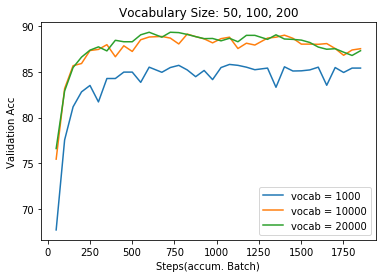

In [201]:
# visualization 
plt.plot(step_l,val_acc_l_LR_noclean,label = 'Token Clean = No')
plt.plot(step_l,val_acc_l_LR_dic20000,label = 'Token Clean = Yes')
plt.xlabel('Steps(accum. Batch)')
plt.ylabel('Validation Acc')
plt.title('Vocabulary Size: 50, 100, 200')
plt.legend()
plt.show()

In [162]:
step_ = []
for i in range(len(val_acc_l_LR_10epc)):
    step_.append(1+50*(i+1))

In [203]:
max(val_acc_l_LR_dic1000), max(val_acc_l_LR_dic10000), max(val_acc_l_LR_dic20000)

(85.82, 89.14, 89.34)

Experiment on N-grams [`1`,`2`,`3`,`4`]

In [34]:
gram_list = [all_train_tokens, train_data_tokens_2, train_data_tokens_3, train_data_tokens_4]
train_data_tokens_list = [train_data_tokens, train_data_tokens_2_train, train_data_tokens_3_train, train_data_tokens_4_train]

In [35]:
val_data_tokens_list = [val_data_tokens,val_data_tokens_2_val,val_data_tokens_3_val,val_data_tokens_4_val]
test_data_tokens_list = [test_data_tokens,test_data_tokens_2_test,test_data_tokens_3_test,test_data_tokens_4_test]

This is the results for N-gram = 1
Token id 3880 ; token trio
Token trio; token id 3880
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
The maximum sentense length is 9955
Epoch: [1/3], Step: [51/625], Validation Acc: 50.04
Epoch: [1/3], Step: [101/625], Validation Acc: 50.5
Epoch: [1/3], Step: [151/625], Validation Acc: 79.68
Epoch: [1/3], Step: [201/625], Validation Acc: 82.72
Epoch: [1/3], Step: [251/625], Validation Acc: 81.26
Epoch: [1/3], Step: [301/625], Validation Acc: 84.78
Epoch: [1/3], Step: [351/625], Validation Acc: 84.96
Epoch: [1/3], Step: [401/625], Validation Acc: 80.24
Epoch: [1/3], Step: [451/625], Validation Acc: 87.14
Epoch: [1/3], Step: [501/625], Validation Acc: 86.98
Epoch: [1/3], Step: [551/625], Validation Acc: 87.24
Epoch: [1/3], Step: [601/625], Validation Acc: 88.16
Epoch: [2/3], Step: [51/625], Validation Acc: 87.46
Epoch: [2/3], Step: [101/625], Validation Acc: 87.56
Epoch: [2/3], Step: [151/625], Validation Acc: 87.36
Epoc

Epoch: [1/3], Step: [251/625], Validation Acc: 85.12
Epoch: [1/3], Step: [301/625], Validation Acc: 86.14
Epoch: [1/3], Step: [351/625], Validation Acc: 86.48
Epoch: [1/3], Step: [401/625], Validation Acc: 86.82
Epoch: [1/3], Step: [451/625], Validation Acc: 87.26
Epoch: [1/3], Step: [501/625], Validation Acc: 87.66
Epoch: [1/3], Step: [551/625], Validation Acc: 87.58
Epoch: [1/3], Step: [601/625], Validation Acc: 86.56
Epoch: [2/3], Step: [51/625], Validation Acc: 88.4
Epoch: [2/3], Step: [101/625], Validation Acc: 87.08
Epoch: [2/3], Step: [151/625], Validation Acc: 88.28
Epoch: [2/3], Step: [201/625], Validation Acc: 88.3
Epoch: [2/3], Step: [251/625], Validation Acc: 87.52
Epoch: [2/3], Step: [301/625], Validation Acc: 89.52
Epoch: [2/3], Step: [351/625], Validation Acc: 89.22
Epoch: [2/3], Step: [401/625], Validation Acc: 89.48
Epoch: [2/3], Step: [451/625], Validation Acc: 86.0
Epoch: [2/3], Step: [501/625], Validation Acc: 85.9
Epoch: [2/3], Step: [551/625], Validation Acc: 87.9

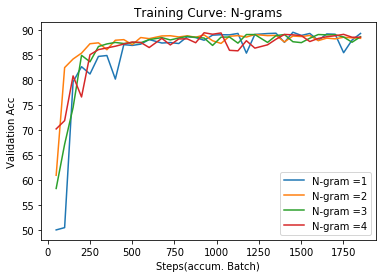

In [41]:
for n in range(len(gram_list)):
    print('This is the results for N-gram =',n+1)
    # genenrate token2id
    token2id, id2token = build_vocab(gram_list[n], max_vocab_size = 10000)
    random_token_id = random.randint(0, len(id2token)-1)
    random_token = id2token[random_token_id]
    print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
    print ("Token {}; token id {}".format(random_token, token2id[random_token]))
    
    train_data_indices = token2index_dataset(train_data_tokens_list[n])
    val_data_indices = token2index_dataset(val_data_tokens_list[n])
    test_data_indices = token2index_dataset(test_data_tokens_list[n])

    # double checking
    print ("Train dataset size is {}".format(len(train_data_indices)))
    print ("Val dataset size is {}".format(len(val_data_indices)))
    print ("Test dataset size is {}".format(len(test_data_indices)))
    
    # calcualte the maximum sentence length
    sentence_len = []
    for i in range(len(train_data_indices)):
        sentence_len.append(len(train_data_indices[i]))
    MAX_SENTENCE_LENGTH = max(sentence_len)
    print('The maximum sentense length is',MAX_SENTENCE_LENGTH)
    # construct loaders
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    # set-up model
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)
    
    learning_rate = 0.01
    num_epochs = 3 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    
    # run model 
    val_acc_l = []
    step_l = []
    for epoch in range(num_epochs):
        #scheduler.step(epoch)
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            # have to zero them out at the start of a new minibatch
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 50 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_l.append(val_acc)
                step_l.append(i+1) 
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    print(val_acc_l)
    print(step_l)
    print('the max validation:', max(val_acc_l))
    step_l= [x + y for x, y in zip(f, step_l)]            
    # ploting the training curve
    plt.plot(step_l,val_acc_l, label = 'N-gram ='+str(n+1))
    print('************************************')
    
# plot frame setting    
plt.xlabel('Steps(accum. Batch)')
plt.ylabel('Validation Acc')
plt.title('Training Curve: N-grams')
plt.legend()
plt.show()

Error Analysis

In [66]:
# Function for generate samples the model
def generate_samples_results(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    correct_sample = []
    incorrect_sample = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        for i, pred in enumerate(predicted): 
            if pred == label_batch[i]:
                correct_sample.append((val_data[i],pred,val_targets[i]))
            else:
                incorrect_sample.append((val_data[i],pred,val_targets[i]))
        break
    return correct_sample, incorrect_sample

In [67]:
correct_sample, incorrect_sample = generate_samples_results(val_loader, model)

In [69]:
correct_sample[:3]

[("there are enough sad stories about women and their oppression by religious political and societal means not to diminish the films and stories about genital mutilation and reproductive rights as well as wage inequality and marginalization in society all in the name of allah or god or some other ridiculous justification but sometimes it is helpful to just take another approach and shed some light on the subject the setting is the 2006 match between iran and bahrain to qualify for the world cup passions are high and several women try to disguise themselves as men to get into the match the women who were caught played by sima mobarakshahi shayesteh irani ayda sadeqi golnaz farmani and mahnaz zabihi and detained for prosecution provided a funny and illuminating glimpse into the customs of this country and most likely all muslim countries their interaction with the iranian soldiers who were guarding and transporting them both city and villagers and the father who was looking for his daugh

In [71]:
incorrect_sample[-3:]

[('a series of shorts spoofing dumb tv shows groove tube hits and misses a lot overall i do really like this movie unfortunately a couple of the segments are totally boring a few really great clips make up for this a predecessor to such classics like kentucky fried movie',
  tensor([0]),
  1),
 ("i love ghost stories in general but i particularly love chilly atmospheric and elegantly creepy british periodstyle ghost stories this one qualifies on all counts a naive young lawyer solicitor in britspeak is sent to a small village near the seaside to settle an elderly deceased woman's estate it's the 1920s a time when many middleclass brits go to the seaside on vacation for their health well guess what there's nothing healthy about the village of crythin gifford the creepy site of the elderly woman's hulking brooding victorian estate which is located on the fringes of a fogswathed salt marsh when the lawyer saves the life of a small girl none of the locals will help the endangered tot you f

Additional exploriation: Batch Size

Epoch: [1/3], Step: [51/625], Validation Acc: 70.64
Epoch: [1/3], Step: [101/625], Validation Acc: 81.64
Epoch: [1/3], Step: [151/625], Validation Acc: 84.76
Epoch: [1/3], Step: [201/625], Validation Acc: 86.6
Epoch: [1/3], Step: [251/625], Validation Acc: 87.28
Epoch: [1/3], Step: [301/625], Validation Acc: 87.8
Epoch: [1/3], Step: [351/625], Validation Acc: 88.44
Epoch: [1/3], Step: [401/625], Validation Acc: 87.92
Epoch: [1/3], Step: [451/625], Validation Acc: 88.46
Epoch: [1/3], Step: [501/625], Validation Acc: 88.92
Epoch: [1/3], Step: [551/625], Validation Acc: 89.46
Epoch: [1/3], Step: [601/625], Validation Acc: 89.64
Epoch: [2/3], Step: [51/625], Validation Acc: 89.62
Epoch: [2/3], Step: [101/625], Validation Acc: 88.96
Epoch: [2/3], Step: [151/625], Validation Acc: 89.52
Epoch: [2/3], Step: [201/625], Validation Acc: 88.88
Epoch: [2/3], Step: [251/625], Validation Acc: 89.24
Epoch: [2/3], Step: [301/625], Validation Acc: 89.2
Epoch: [2/3], Step: [351/625], Validation Acc: 89.2

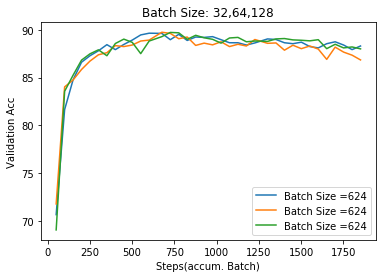

In [83]:
for i in [32, 64, 128]:
    ATCH_SIZE = i
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)
    learning_rate = 0.01
    num_epochs = 3 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    
    # run model 
    val_acc_l = []
    step_l = []
    for epoch in range(num_epochs):
        #scheduler.step(epoch)
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            # have to zero them out at the start of a new minibatch
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 50 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_l.append(val_acc)
                step_l.append(i+1) 
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    print(val_acc_l)
    print(step_l)
    print('the max validation:', max(val_acc_l))
    step_l= [x + y for x, y in zip(f, step_l)]            
    # ploting the training curve
    plt.plot(step_l,val_acc_l, label = 'Batch Size ='+ str(i))
    print('************************************')
    
# plot frame setting    
plt.xlabel('Steps(accum. Batch)')
plt.ylabel('Validation Acc')
plt.title('Batch Size: 32,64,128')
plt.legend()
plt.show()

Test Accurary

In [50]:
print ("Test Acc {}".format(test_model(test_loader, model)))

Test Acc 88.76
